In [1]:
# initial import statements
from tomopt.core import *
from tomopt.core import X0
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
from functools import partial

from tomopt.volume import PassiveLayer, PanelDetectorLayer, DetectorPanel, Volume
from tomopt.optimisation import PassiveYielder, PanelVolumeWrapper, DetectorLoss, NoMoreNaNs, PanelMetricLogger, CostCoefWarmup

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# INITIALIZATIONS

DEVICE = torch.device('cpu')

# Defining cost of detectors
def area_cost(x:Tensor)->Tensor:
    return F.relu(x)

# Constructing volume layer by layer
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size=0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 3
    
    layers.append(PanelDetectorLayer(pos='above',
                                     lw=lwh[:2],
                                     z=1,
                                     size=2*size,
                                     panels=[
                                         DetectorPanel(
                                             res=init_res, 
                                             eff=init_eff,
                                             init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)],
                                             init_xy_span=[1.,1.],
                                             area_cost_func=area_cost,
                                             device=DEVICE) for i in range(n_panels)
                                     ]
                                    ))
    
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    
    layers.append(PanelDetectorLayer(pos='below',
                                     lw=lwh[:2],
                                     z=0.2,
                                     size=2*size,
                                     panels=[
                                         DetectorPanel(
                                             res=init_res,
                                             eff=init_eff,
                                             init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)],
                                             init_xy_span=[1.,1.],
                                             area_cost_func = area_cost,
                                             device=DEVICE) for i in range(n_panels)                                         
                                     ]
                                    ))
    return nn.ModuleList(layers)

# feed layers into a single object
volume = Volume(get_layers())    

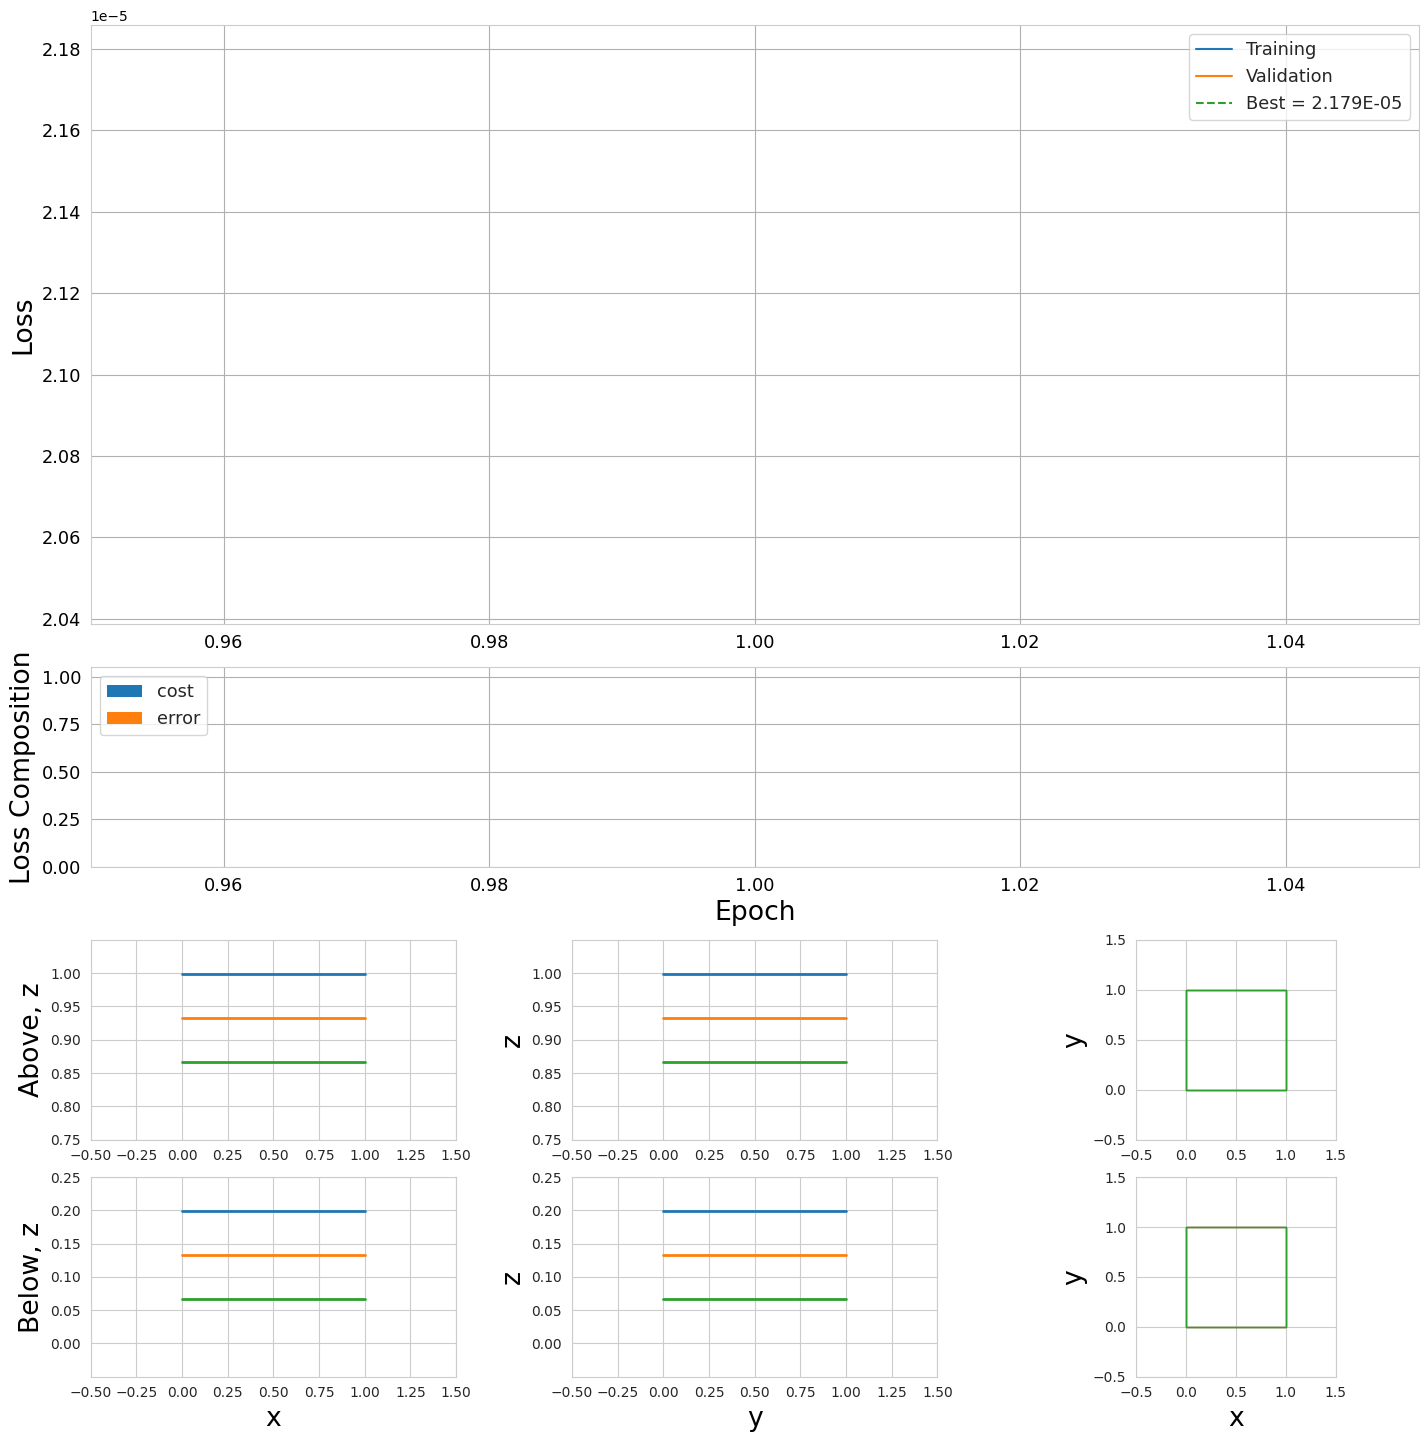

Automatically setting cost coefficient to 4.545632236840902e-06


/home/federico/Documents/Projects/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:211: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


In [ ]:
# OPTIMIZATION
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD,lr=5e3),
                             z_pos_opt=partial(torch.optim.SGD,lr=5e2),
                             xy_span_opt=partial(torch.optim.SGD,lr=1e4),
                             loss_func=DetectorLoss(target_budget=4,cost_coef=None)
                            )

# Define composition of passive volume
def arb_rad_length(*, z:float, lw:Tensor, size:float)->Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z>=0.4 and z<=0.5: rad_length[5:,5:]=X0['lead']
    return rad_length

passives=PassiveYielder([arb_rad_length])

# fit
_ = wrapper.fit(n_epochs=50,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefWarmup(n_warmup=5),NoMoreNaNs(),PanelMetricLogger()]
               )